In [ ]:
# ai_art_classification/
# ├── train/
# │   ├── AI_GENERATED/         ← fake → label = 1
# │   └── NON_AI_GENERATED/     ← real → label = 0
# ├── test/

In [37]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ai_art_classification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/ai_art_classification/train/NON_AI_GENERATED/8898.jpg  
  inflating: /content/__MACOSX/ai_art_classification/train/NON_AI_GENERATED/._8898.jpg  
  inflating: /content/ai_art_classification/train/NON_AI_GENERATED/496.jpg  
  inflating: /content/__MACOSX/ai_art_classification/train/NON_AI_GENERATED/._496.jpg  
  inflating: /content/ai_art_classification/train/NON_AI_GENERATED/1102.jpg  
  inflating: /content/__MACOSX/ai_art_classification/train/NON_AI_GENERATED/._1102.jpg  
  inflating: /content/ai_art_classification/train/NON_AI_GENERATED/3073.jpg  
  inflating: /content/__MACOSX/ai_art_classification/train/NON_AI_GENERATED/._3073.jpg  
  inflating: /content/ai_art_classification/train/NON_AI_GENERATED/18276.jpg  
  inflating: /content/__MACOSX/ai_art_classification/train/NON_AI_GENERATED/._18276.jpg  
  inflating: /content/ai_art_classification/train/NON_AI_GENERATED/14464.jpg  
  inflating: /content/__MACOSX/ai_a

In [4]:
import os

base_dir = "/content/ai_art_classification"
print("Train folders:", os.listdir(os.path.join(base_dir, "train")))

Train folders: ['AI_GENERATED', 'NON_AI_GENERATED']


In [31]:
# Extract Features with DINOv2

import os
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm

# Load DINOv2
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base")
model.eval()

def extract_dino_features(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [1, 768]
    return cls_embedding.squeeze().numpy()

In [48]:
# Build feature dataset

import numpy as np

# Set data path
data_dir = "ai_art_classification/train"
label_map = {
    "NON_AI_GENERATED": 0,
    "AI_GENERATED": 1}


X, y, image_paths = [], [], []

for class_name, label in label_map.items():
    class_path = os.path.join(data_dir, class_name)
    for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path).convert("RGB")
            feat = extract_dino_features(img_path)
            X.append(feat)
            y.append(label)
            image_paths.append(img_path)  # ✅ ADD THIS LINE
        except Exception as e:
            print(f"Failed to process {img_file}: {e}")

X = np.array(X)
y = np.array(y)
image_paths = np.array(image_paths)

# Save to disk
os.makedirs("features", exist_ok=True)
np.savez_compressed("/content/drive/MyDrive/dino_features_train.npz", X=X, y=y)
print("✅ Features saved to features/dino_features_train.npz")

Processing AI_GENERATED: 100%|██████████| 10330/10330 [13:42<00:00, 12.56it/s]


✅ Features saved to features/dino_features_train.npz


In [36]:
!cp /content/features/dino_features_train.npz /content/drive/MyDrive/

cp: cannot stat '/content/features/dino_features_train.npz': No such file or directory


In [ ]:
!ls -lh /content/features

total 51M
-rw-r--r-- 1 root root 51M May 16 02:34 dino_features_train.npz


In [40]:
import numpy as np

data = np.load("/content/drive/MyDrive/dino_features_train.npz")
X = data["X"]
y = data["y"]
print("Loaded features:", X.shape, y.shape)

Loaded features: (18618, 768) (18618,)


In [41]:
# train classifier

import os
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.calibration import CalibratedClassifierCV


# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

base_svc = LinearSVC()
clf = CalibratedClassifierCV(base_svc)
clf.fit(X_train, y_train)

# clf = LinearSVC(dual=False, max_iter=5000)
# clf.fit(X_train, y_train)

# Save model
os.makedirs("model", exist_ok=True)
joblib.dump(clf, "model/svm_model2.pkl")
print("✅ Model saved to model/svm_model2.pkl")

✅ Model saved to model/svm_model2.pkl


In [ ]:
!cp /content/model/svm_model1.pkl /content/drive/MyDrive/

In [42]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Accuracy
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Human-made", "AI-generated"]))

# Confusion matrix
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 90.68%

 Classification Report:
              precision    recall  f1-score   support

  Human-made       0.91      0.88      0.89      1658
AI-generated       0.91      0.93      0.92      2066

    accuracy                           0.91      3724
   macro avg       0.91      0.90      0.91      3724
weighted avg       0.91      0.91      0.91      3724


 Confusion Matrix:
[[1462  196]
 [ 151 1915]]


---
## Attention maps

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import joblib

clf = joblib.load("/content/drive/MyDrive/svm_model1.pkl")

In [44]:
import numpy as np

data = np.load("/content/drive/MyDrive/dino_features_train.npz")
X = data["X"]
y = data["y"]

In [45]:
y_pred = clf.predict(X)

In [51]:
# Function to get attention map
def get_cls_attention_map(img_path, head=0):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attn_maps = outputs.attentions[-1]  # last layer
    cls_attn = attn_maps[0, :, 0, 1:].mean(dim=0)  # mean over heads
    side = int(cls_attn.shape[0] ** 0.5)
    cls_attn_map = cls_attn.reshape(side, side).cpu().numpy()

    return cls_attn_map, image

# Function to overlay heatmap on image
def overlay_attention_on_image(att_map, image, alpha=0.6, title="CLS Attention Overlay"):
    image = image.resize((224, 224))  # DINOv2 uses 224x224
    att_map_resized = Image.fromarray((att_map / att_map.max() * 255).astype(np.uint8)).resize((224, 224), resample=Image.BILINEAR)
    att_map_resized = np.array(att_map_resized)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(att_map_resized, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.title(title)
    plt.show()

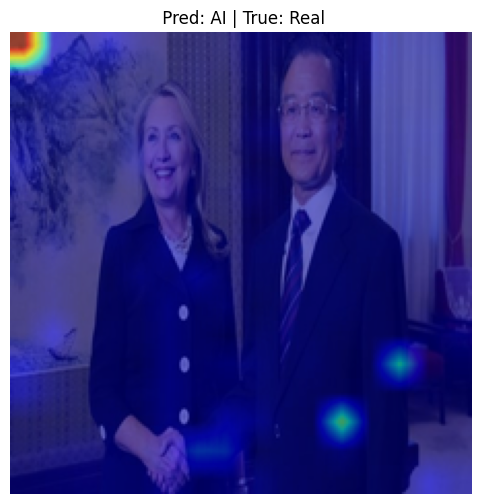

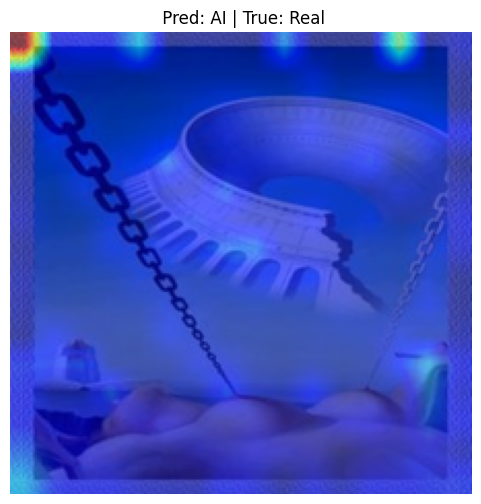

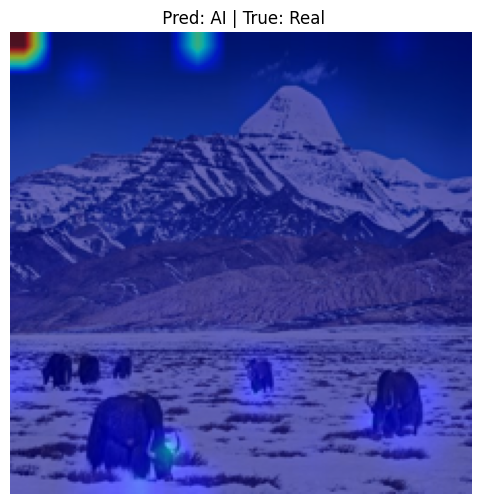

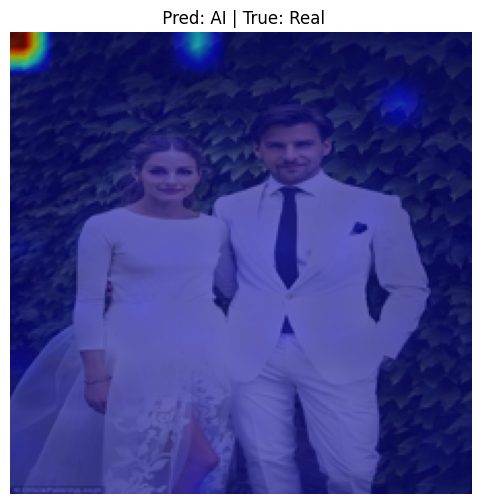

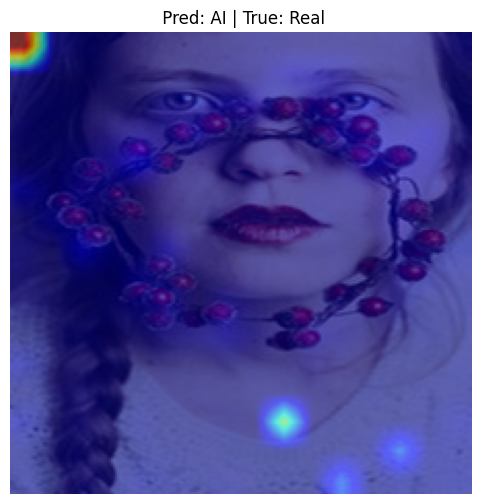

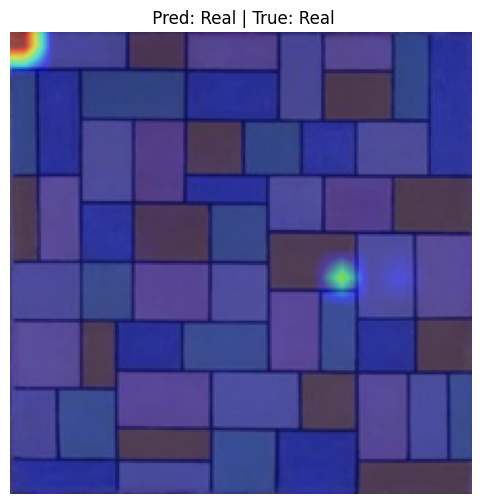

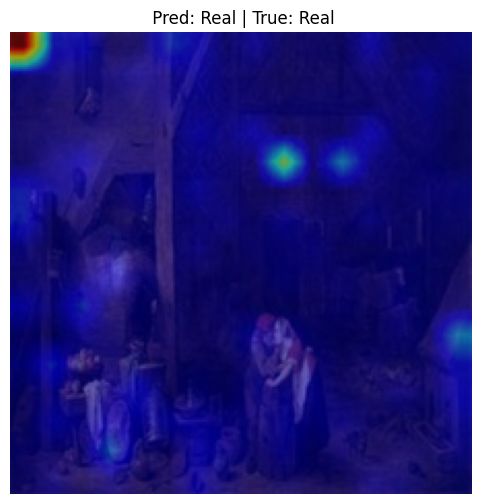

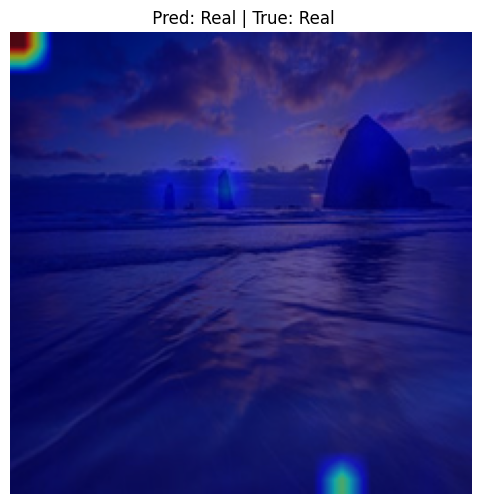

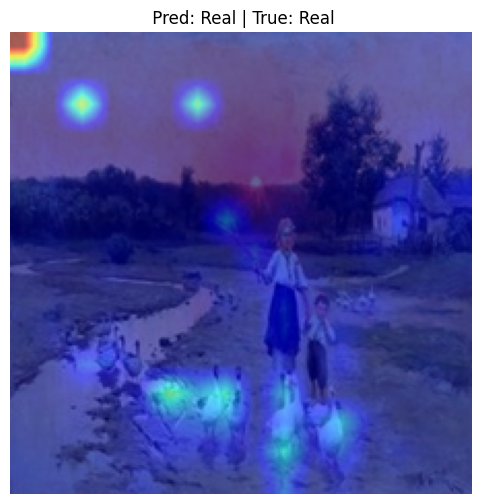

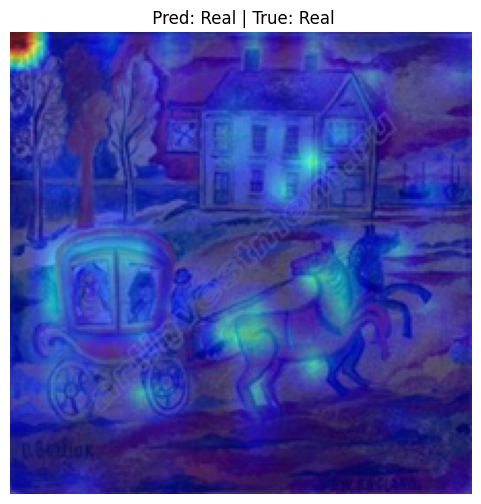

In [53]:
# Get indices for predicted AI (label=1) and non-AI (label=0)
ai_pred_indices = [i for i, p in enumerate(y_pred) if p == 1]
nonai_pred_indices = [i for i, p in enumerate(y_pred) if p == 0]

# Visualize 5 predicted AI images
for idx in ai_pred_indices[:5]:
    img_path = image_paths[idx]
    att_map, image = get_cls_attention_map(img_path, head=0)

    pred_label = y_pred[idx]
    true_label = y[idx]

    title = f" Pred: {'AI' if pred_label == 1 else 'Real'} | True: {'AI' if true_label == 1 else 'Real'}"
    overlay_attention_on_image(att_map, image, alpha=0.6, title=title)

# Visualize 5 predicted non-AI images
for idx in nonai_pred_indices[:5]:
    img_path = image_paths[idx]
    att_map, image = get_cls_attention_map(img_path, head=0)

    pred_label = y_pred[idx]
    true_label = y[idx]

    title = f" Pred: {'AI' if pred_label == 1 else 'Real'} | True: {'AI' if true_label == 1 else 'Real'}"
    overlay_attention_on_image(att_map, image, alpha=0.6, title=title)

### Streamlit app web demo

In [ ]:
# your_project/
# ├── app.py                  ← Streamlit app
# ├── model/
# │   └── svm_model.pkl       ← Trained classifier
# ├── utils/
# │   └── dino_features.py    ← Feature extractor

In [ ]:
#  dino_features.py (feature extraction)

# utils/dino_features.py
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
import numpy as np

# Load DINOv2 base once
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base")
model.eval()

def extract_dino_feature(image: Image.Image) -> np.ndarray:
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [1, 768]
    return cls_token.squeeze().numpy()

In [ ]:
#  app.py (Streamlit UI)

# app.py

import streamlit as st
import joblib
from PIL import Image
from utils.dino_features import extract_dino_feature
import numpy as np
import matplotlib.pyplot as plt

# Page title
st.set_page_config(page_title="AI Art Fake Detection", layout="centered")
st.title("🎨 AI Art Fake Detection App")
st.write("Upload an artwork to predict whether it's **human-made** or **AI-generated** using DINOv2 features + SVM classifier.")

# Upload image
uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

# Prediction logic
if uploaded_file:
    # Show image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Artwork", use_column_width=True)

    st.info("🔍 Extracting features using DINOv2...")
    features = extract_dino_feature(image).reshape(1, -1)

    # Load trained model
    clf = joblib.load("model/svm_model.pkl")

    # Prediction
    prob = clf.predict_proba(features)[0]
    pred = clf.predict(features)[0]

    # Output result
    label = "🧠 Human-made" if pred == 0 else "🤖 AI-generated"
    st.subheader(f"Prediction: {label}")
    st.write(f"Confidence: {prob[pred]*100:.2f}%")

    # Confidence bar chart
    st.write("### 🔎 Prediction Confidence")
    classes = ["Human-made", "AI-generated"]
    colors = ["#4CAF50", "#FF5722"]

    fig, ax = plt.subplots()
    bars = ax.bar(classes, prob * 100, color=colors)
    ax.set_ylim([0, 100])
    ax.set_ylabel("Confidence (%)")
    ax.set_title("Prediction Confidence")

    # Annotate bars
    for bar, p in zip(bars, prob):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + 1, f"{p*100:.1f}%", ha='center')

    st.pyplot(fig)

# Footer
st.markdown("---")
st.caption("Built using DINOv2, Streamlit, and scikit-learn.")

In [ ]:
!streamlit run app.py